# 4.

model performance overview

In [240]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

In [104]:
F = pd.read_csv('features.csv')

In [105]:
split_date = '2022-10-01'

In [106]:
F.columns

Index(['ticker', 'earnings_date', 'eps_est', 'eps_actual', 'eps_diff',
       'eps_diff_pct', 'tot_assets', 'common_stock', 'tot_cap', 'tot_debt',
       'net_debt', 'ord_shares', 'tot_reve', 'gross_profit', 'op_expense',
       'op_income', 'avg_shares', 'prev_eps_actual', 'prev_eps_diff',
       'eps_q_change', 'eps_q_change_pct', 'expense_to_income',
       'assets_to_profit', 'debt_to_debt', 'debt_to_cap', 'profit_to_reve',
       'on_earnings_close', 'on_earnings_volume', 'market_cap',
       'history_start_date', 'history_end_date', 'price_min', 'price_max',
       'tgt'],
      dtype='object')

In [232]:
X = F[['eps_est', 'eps_actual', 'eps_diff',
       'eps_diff_pct', 
       #'tot_assets', 'common_stock', 'tot_cap', 'tot_debt',
       #'net_debt', 'ord_shares', 'tot_reve', 'gross_profit', 'op_expense',
       #'op_income', 'avg_shares', 'prev_eps_actual', 'prev_eps_diff',
       #'expense_to_income',
       #'eps_q_change', 'eps_q_change_pct',
       #'assets_to_profit', 'profit_to_reve',
       'debt_to_debt', 'debt_to_cap', 
       'on_earnings_close', 'on_earnings_volume', 
       'market_cap']]
y = F[['tgt']]
INFO = F[['ticker', 'earnings_date','history_start_date', 'history_end_date', 'price_min', 'price_max','tgt']]

In [233]:
ndx_train = INFO[INFO.earnings_date< split_date].index.to_list()
ndx_test  = INFO[INFO.earnings_date>=split_date].index.to_list()
len(ndx_test)/len(ndx_train)

0.24489795918367346

In [234]:
X_train,    X_test    = X.iloc[ndx_train],    X.iloc[ndx_test]
y_train,    y_test    = y.iloc[ndx_train],    y.iloc[ndx_test]
INFO_train, INFO_test = INFO.iloc[ndx_train], INFO.iloc[ndx_test]

## training!

### xgb

In [111]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(xg_train, "train"), (xg_test, "test")]

In [169]:
param = {
    "objective": "binary:logistic",
    "learning_rate": 0.3,
    "subsample": 0.8,
    "max_depth": 2,
    'colsample_bytree': 1.0, # nie zmieniac
    "min_child_weight": 0, # invariant
    "reg_lambda": 0.9, # nie zmieniac
    "seed": 0, # dziwne: wszystkie inne oprocz 0 daja ok 70%
    "nthread" : 4,
}
num_round = 1

clf = xgb.train(
    param, xg_train, num_round, evals=watchlist, 
    #callbacks=[WandbCallback()]
)

y_pred = clf.predict(xg_test)
y_pred = (y_pred>0.5).astype(int)

cm=confusion_matrix(y_test, y_pred)
print(cm)
print("precision:",cm[1][1]/(cm[0][1]+cm[1][1]))

[0]	train-logloss:0.68317	test-logloss:0.70352
[[109   4]
 [227  20]]
precision: 0.8333333333333334


### gbt

In [251]:
clf = GradientBoostingClassifier(
    learning_rate = 0.05, 
    n_estimators = 50, 
    subsample = .9,
    random_state=7
)

clf.fit(X_train, y_train['tgt'])

print("on train precision:",precision_score(y_train.to_numpy()[:,0], clf.predict(X_train)))
y_pred_proba = clf.predict_proba(X_test)
y_pred = (y_pred_proba[:,1]>0.5).astype(int)

cm = confusion_matrix(y_test.to_numpy()[:,0], y_pred)
p  = precision_score(y_test.to_numpy()[:,0], y_pred)
total_pos = cm[:,1].sum()
min_trades_in_period = 50 #8
quantity_score = min(total_pos/min_trades_in_period, 1.0) # have at least min_trades otherwise, fall hyperbolically
SCORE = p * quantity_score # score to maximize: tradeoff between precision and quantity

res = {
    'total_pos': total_pos,
    'precision': p,
    'quantity' : quantity_score,
    'score'    : SCORE
}

print(res)

pd.DataFrame({'feature':X.columns.to_list(),'importance':clf.feature_importances_}).set_index('feature').sort_values(by='importance',ascending=False)


on train precision: 0.7518427518427518
{'total_pos': 94, 'precision': 0.7659574468085106, 'quantity': 1.0, 'score': 0.7659574468085106}


,importance
feature,
on_earnings_volume,0.176045
on_earnings_close,0.164162
eps_est,0.153489
market_cap,0.138776
debt_to_debt,0.107270
eps_actual,0.085557
eps_diff_pct,0.062095
debt_to_cap,0.057139
eps_diff,0.055467


Text(0, 0.5, 'True Positive rate')

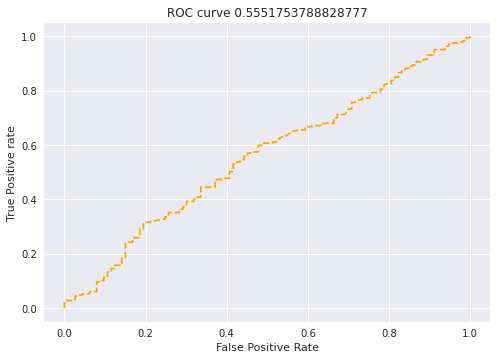

In [252]:
# ROC = AUC
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])

import matplotlib.pyplot as plt
plt.style.use('seaborn')

plt.plot(fpr1, tpr1, linestyle='--',color='orange')
# title
plt.title(f'ROC curve {auc_score}')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')